# 1. Extract features of training and test images using a pre-trained ResNet50 model (50 points)
Please print the size of extracted features, e.g., training features: 1400 * d, test features: 400 *d.

In [18]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load pre-trained ResNet50 model and remove the final fully connected layer
resnet50_model = torchvision.models.resnet50(pretrained=True)
resnet50_model = torch.nn.Sequential(*list(resnet50_model.children())[:-1])  # Remove last fully connected layer
resnet50_model.eval()  # Set the model to evaluation mode

# Transform for images (resize and normalize them the same way as pre-trained models expect)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset (use your own data directory path)
train_dir = 'C:/Users/acer/Downloads/Dog_heart/Dog_heart/Train'  # Update this path
test_dir = 'C:/Users/acer/Downloads/Dog_heart/Dog_heart/Valid'  # Update this path

# Load images
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader to fetch images in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to extract features
def extract_features(data_loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            outputs = model(inputs)  # Output is of shape (batch_size, 2048, 1, 1)
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())  # Flatten and move to CPU
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

# Extract training and testing features
train_features, train_labels = extract_features(train_loader, resnet50_model)
test_features, test_labels = extract_features(test_loader, resnet50_model)

# Print the size of extracted features
print(f"Training features: {train_features.shape[0]} * {train_features.shape[1]}")
print(f"Test features: {test_features.shape[0]} * {test_features.shape[1]}")


C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training features: 1400 * 2048
Test features: 200 * 2048


# 2. Call SVM and kNN from scikit-learn and train the extracted deep features, respectively (30 points)

In [24]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Train SVM classifier
svm_clf = SVC(kernel='linear', class_weight='balanced')  # Optional: class_weight='balanced' for imbalanced data
svm_clf.fit(train_features, train_labels)

# Predict on test data using SVM
svm_preds = svm_clf.predict(test_features)
svm_accuracy = accuracy_score(test_labels, svm_preds)
print(f"SVM accuracy: {svm_accuracy * 100:.2f}%")

# Train kNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(train_features, train_labels)

# Predict on test data using kNN
knn_preds = knn_clf.predict(test_features)
knn_accuracy = accuracy_score(test_labels, knn_preds)
print(f"kNN accuracy: {knn_accuracy * 100:.2f}%")


SVM accuracy: 61.50%
kNN accuracy: 56.50%


In [30]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load pre-trained ResNet50 model and remove the final fully connected layer
resnet50_model = torchvision.models.resnet50(pretrained=True)
resnet50_model = torch.nn.Sequential(*list(resnet50_model.children())[:-1])  # Remove last fully connected layer
resnet50_model.eval()  # Set the model to evaluation mode

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model = resnet50_model.to(device)

# Transform for images (resize and normalize them the same way as pre-trained models expect)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset (use your own data directory path)
train_dir = 'C:/Users/acer/Downloads/Dog_heart/Dog_heart/Train'  # Update this path
test_dir = 'C:/Users/acer/Downloads/Dog_heart/Dog_heart/Valid'  # Update this path

# Load images
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader to fetch images in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle for training
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffle for testing

# Function to extract features
def extract_features(data_loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)  # Move inputs to the device
            outputs = model(inputs)  # Output is of shape (batch_size, 2048, 1, 1)
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())  # Flatten and move to CPU
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

# Extract training and testing features
train_features, train_labels = extract_features(train_loader, resnet50_model)
test_features, test_labels = extract_features(test_loader, resnet50_model)

# Train SVM classifier
svm_clf = SVC(kernel='linear', class_weight='balanced')  # Optional: class_weight='balanced' for imbalanced data
svm_clf.fit(train_features, train_labels)

# Predict on test data using SVM
svm_preds = svm_clf.predict(test_features)

# Train kNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(train_features, train_labels)

# Predict on test data using kNN
knn_preds = knn_clf.predict(test_features)

# Saving predictions to two separate CSV files

# SVM Predictions DataFrame
svm_predictions_df = pd.DataFrame({
    'Image_Path': [test_dataset.imgs[i][0] for i in range(len(test_dataset))],  # Getting image paths
    'SVM_Predictions': svm_preds
})

# Save SVM predictions to CSV
svm_predictions_df.to_csv('svm_predictions.csv', index=False)
print(f"SVM predictions saved to 'svm_predictions.csv'")

# kNN Predictions DataFrame
knn_predictions_df = pd.DataFrame({
    'Image_Path': [test_dataset.imgs[i][0] for i in range(len(test_dataset))],  # Getting image paths
    'kNN_Predictions': knn_preds
})

# Save kNN predictions to CSV
knn_predictions_df.to_csv('knn_predictions.csv', index=False)
print(f"kNN predictions saved to 'knn_predictions.csv'")


C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SVM predictions saved to 'svm_predictions.csv'
kNN predictions saved to 'knn_predictions.csv'


# 3. Report the accuracy using Dog_X_ray_classfication_accuracy software, please attach the results image here (20 points)

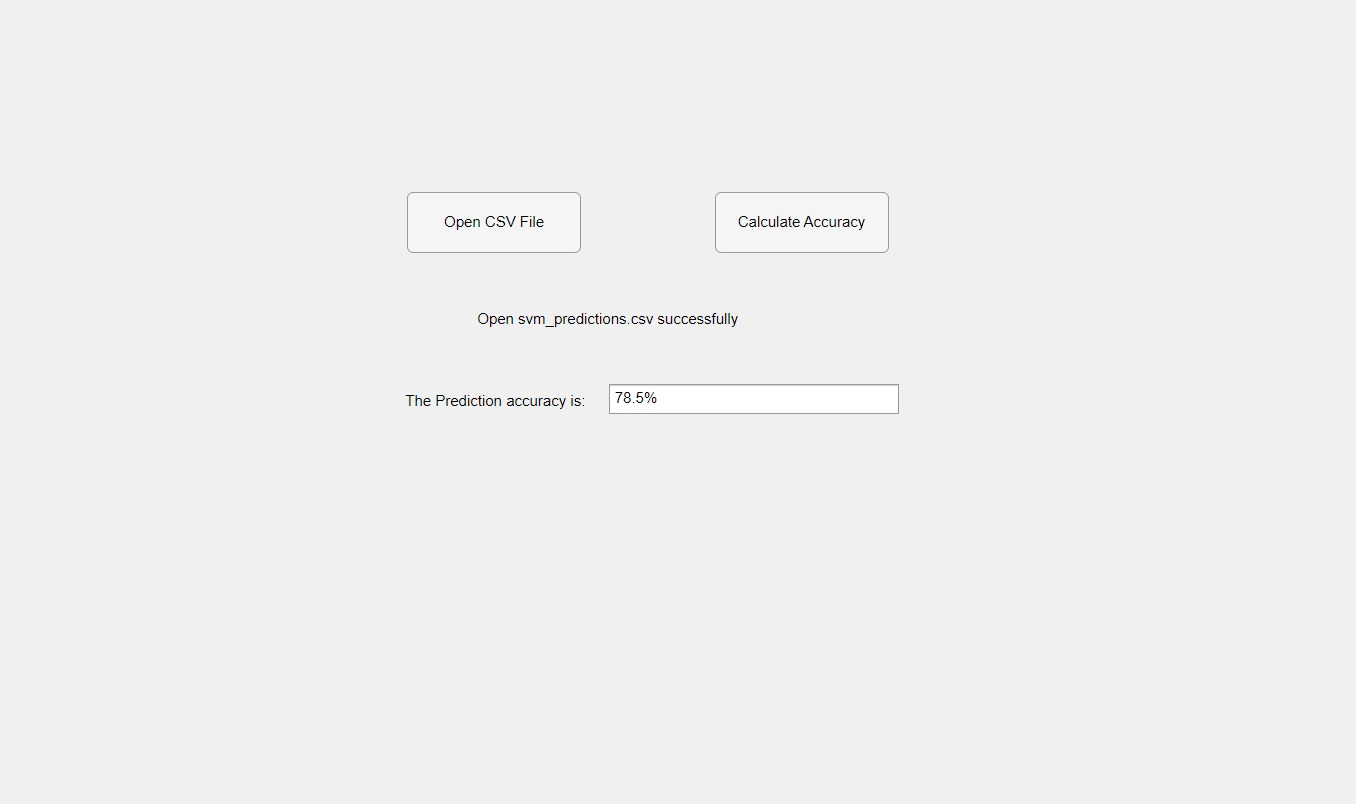

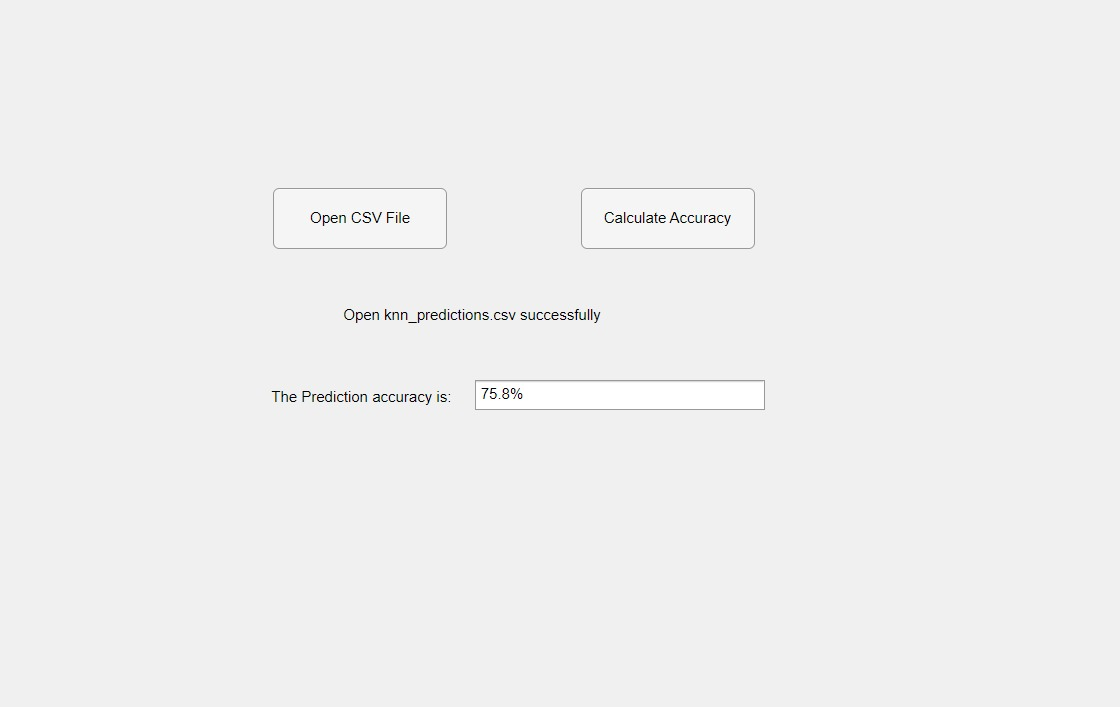